## The Goal: read in data from previous simulations with CLUBB output (monthly) detailing wind variance and skewness. Save a few time averages out as pickle files for easier manipulation. 
Author: Meg D. Fowler <br>
Date: 10 Aug 2020<br><br>

In [219]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker 
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import Ngl
import numpy
import Nio
import os
import numpy as np 
import xarray as xr
from datetime import date, timedelta
import pandas as pd 



## Read in data

In [4]:
# Set up directories 
dataDir    = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
#dataDir   = '/glade/work/mdfowler/data/CLUBB_sim/'   # on Casper/Cheyenne 
nameStart = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd   = '_CLUBBwinds.nc'

decadeList = ['1951-59','1960-69', '1970-79','1980-89','1990-99','2000-14']


In [95]:
# Read in example file to get some constant fields
testName = dataDir+nameStart+'1990-01.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landFrac = np.squeeze(testDF.LANDFRAC.values)
# Define as 'land' gridcell if land fraction > 0.5
landMask = np.zeros([len(lat),len(lon)])
landMask[landFrac > 0.5] = 1


**Plot land mask to make sure this <i>is</i> what I wanted**

Text(0.5, 1.0, 'Land Mask (Sanity Check)')

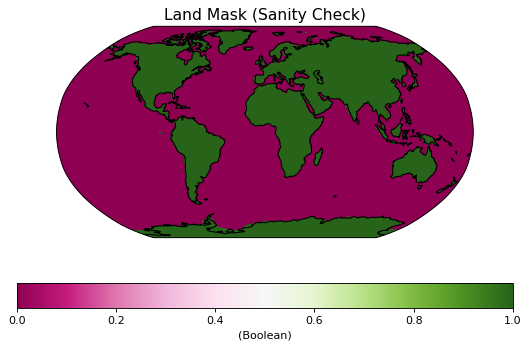

In [99]:
# Plot land mask
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
landMask_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(landMask, lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,landMask_cyclic,cmap='PiYG',transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(Boolean)',orientation='horizontal')
ax.set_title('Land Mask (Sanity Check)', fontsize=14)


**Now start <i>actually</i> reading in data**

In [134]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    fileName = dataDir+nameStart+decadeList[iDec]+nameEnd
    dataDF   = xr.open_dataset(fileName, decode_times=True)
    dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


    PSfile = dataDir+nameStart+decadeList[iDec]+'_PS.nc'
    presDF = xr.open_dataset(PSfile, decode_times=True)
    presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullDF = dataDF
        fullPS = presDF
    else:
        fullDF = xr.concat([fullDF, dataDF], dim="time")
        fullPS = xr.concat([fullPS, presDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullDF['time']))
    

<ipython-input-134-56376860a179>:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-134-56376860a179>:13: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


Done with decade  1951-59  ... 
    Number of times saved:  108
Done with decade  1960-69  ... 
    Number of times saved:  228
Done with decade  1970-79  ... 
    Number of times saved:  348
Done with decade  1980-89  ... 
    Number of times saved:  468
Done with decade  1990-99  ... 
    Number of times saved:  588
Done with decade  2000-14  ... 
    Number of times saved:  768


Since ideally, I'd like to be able to access the time attributes fairly easily, I'm going to put those into a separate pandas array.<br> That way they can be indexed via dates.year, dates.month, etc. <br> 
    
Note: monthly averages are saved at the first time step of the <i>next</i> month. So to get January averages for example, you'd want dates.month==2. <br>

In [136]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullDF['time'].values) 


## Look at some statistics 

In [141]:
# Read into individual arrays for easy access

UP2 = fullDF.UP2_CLUBB      # Zonal velocity variance (m2/s2)
VP2 = fullDF.VP2_CLUBB      # Meridional velocity variance (m2/s2)
WP2 = fullDF.WP2_CLUBB      # Vertical velocity variance (m2/s2)
WP3 = fullDF.WP3_CLUBB      # Third moment vertical velocity (m3/s3)
PS  = fullPS.PS             # Surface pressure (Pa)

np.shape(WP3)

(768, 33, 192, 288)

In [164]:
# Take (annual) time means to look at a few PDFs 
UP2_timeMean = np.squeeze(np.nanmean(UP2, 0))
VP2_timeMean = np.squeeze(np.nanmean(VP2, 0))
WP2_timeMean = np.squeeze(np.nanmean(WP2, 0))
WP3_timeMean = np.squeeze(np.nanmean(WP3, 0))


In [173]:
# --- Compare to seasonal means --- #
iDJF = np.where((dates.month==1) | (dates.month<=3))[0]
iMAM = np.where((dates.month>=4) & (dates.month<=6))[0]
iJJA = np.where((dates.month>=7) & (dates.month<=9))[0]
iSON = np.where((dates.month>=10) & (dates.month<=12))[0]

# DJF 
UP2_DJFmean = np.squeeze(np.nanmean(UP2[iDJF,:,:,:], 0))
VP2_DJFmean = np.squeeze(np.nanmean(VP2[iDJF,:,:,:], 0))
WP2_DJFmean = np.squeeze(np.nanmean(WP2[iDJF,:,:,:], 0))
WP3_DJFmean = np.squeeze(np.nanmean(WP3[iDJF,:,:,:], 0))
print('Done with DJF means')

# MAM 
UP2_MAMmean = np.squeeze(np.nanmean(UP2[iMAM,:,:,:], 0))
VP2_MAMmean = np.squeeze(np.nanmean(VP2[iMAM,:,:,:], 0))
WP2_MAMmean = np.squeeze(np.nanmean(WP2[iMAM,:,:,:], 0))
WP3_MAMmean = np.squeeze(np.nanmean(WP3[iMAM,:,:,:], 0))
print('Done with MAM means')

# JJA
UP2_JJAmean = np.squeeze(np.nanmean(UP2[iJJA,:,:,:], 0))
VP2_JJAmean = np.squeeze(np.nanmean(VP2[iJJA,:,:,:], 0))
WP2_JJAmean = np.squeeze(np.nanmean(WP2[iJJA,:,:,:], 0))
WP3_JJAmean = np.squeeze(np.nanmean(WP3[iJJA,:,:,:], 0))
print('Done with JJA means')

# SON
UP2_SONmean = np.squeeze(np.nanmean(UP2[iSON,:,:,:], 0))
VP2_SONmean = np.squeeze(np.nanmean(VP2[iSON,:,:,:], 0))
WP2_SONmean = np.squeeze(np.nanmean(WP2[iSON,:,:,:], 0))
WP3_SONmean = np.squeeze(np.nanmean(WP3[iSON,:,:,:], 0))
print('Done with SON means')


Done with DJF means
Done with MAM means
Done with JJA means
Done with SON means


### PDFs

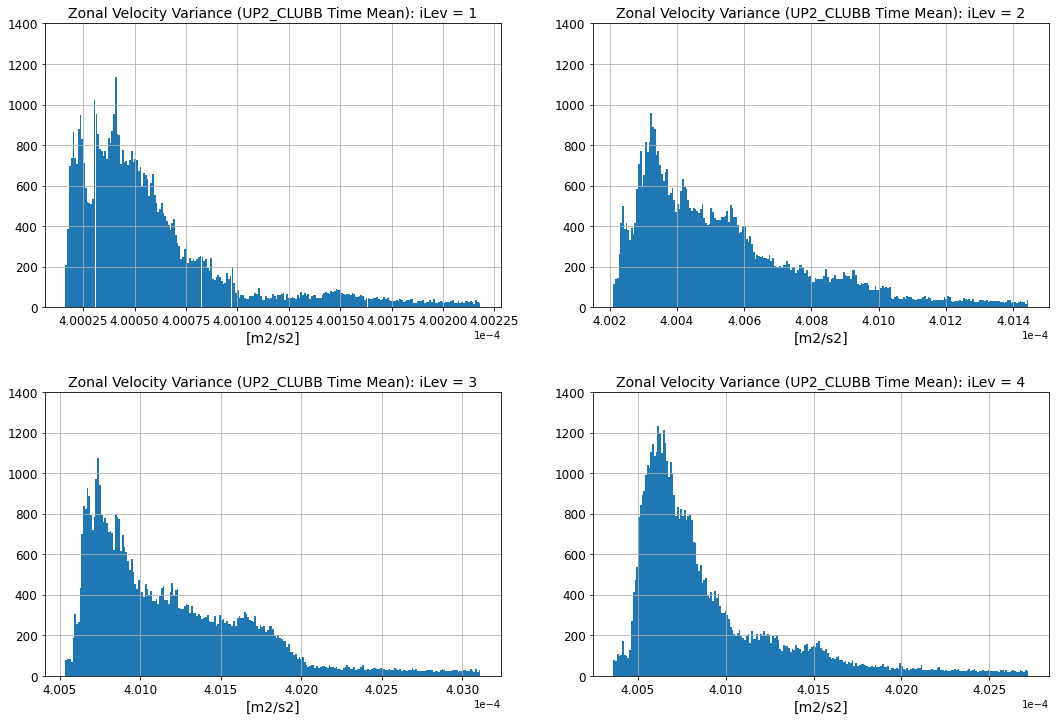

In [233]:
fig, axs = plt.subplots(2,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

for iLev in range(4):
    # Reshape data into 1D array
    UP2_reshape = np.squeeze(UP2_timeMean[iLev+1,:,:]).reshape((len(lat)*len(lon), 1))
    
    # Plot histogram
    axs[iLev].hist(UP2_reshape,np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
    axs[iLev].grid()
    axs[iLev].set_ylim([0,1400])
    axs[iLev].set_title('Zonal Velocity Variance (UP2_CLUBB Time Mean): iLev = '+str(iLev+1), fontsize=14)
    axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))
    axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
    axs[iLev].tick_params(labelsize=12)


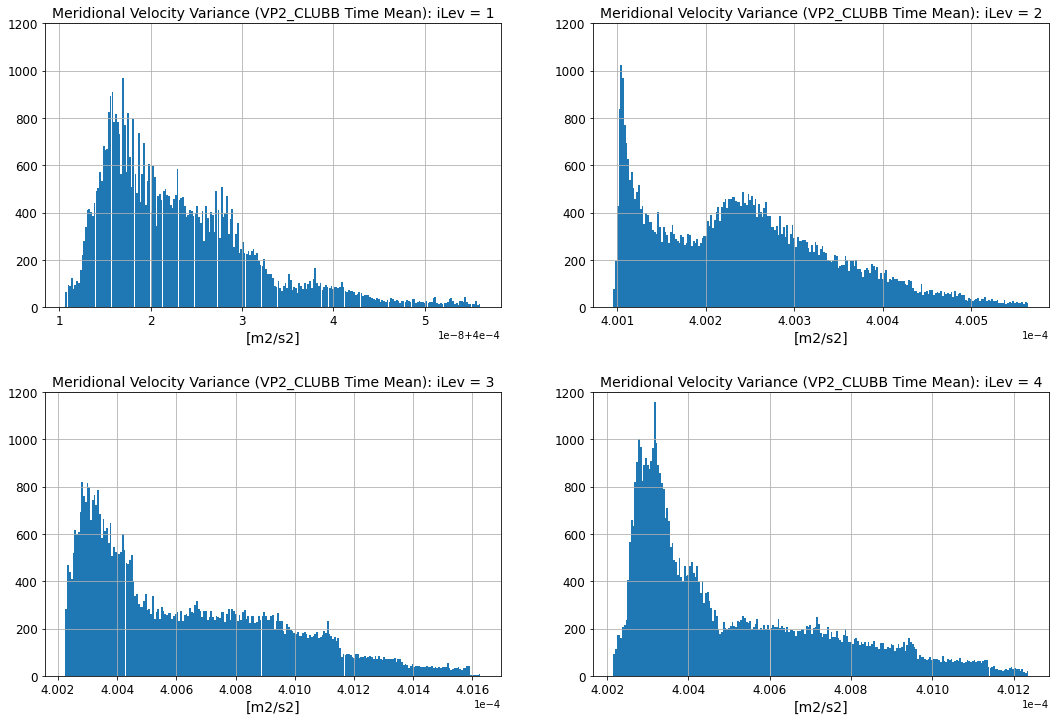

In [236]:
fig, axs = plt.subplots(2,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

for iLev in range(4):
    # Reshape data into 1D array
    VP2_reshape = np.squeeze(VP2_timeMean[iLev+1,:,:]).reshape((len(lat)*len(lon), 1))
    
    # Plot histogram
    axs[iLev].hist(VP2_reshape,np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
    axs[iLev].grid()
    axs[iLev].set_ylim([0,1200])
    axs[iLev].set_title('Meridional Velocity Variance (VP2_CLUBB Time Mean): iLev = '+str(iLev+1), fontsize=14)
    axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))  #Use scientific notation on x-axis
    axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
    axs[iLev].tick_params(labelsize=12)



In [291]:
# Investigate vertical velocity variance at low levels... 

for iLev in range(len(fullDF.ilev)):
    print('iLev = ', iLev)
    print('   Min: %.6e' % np.nanmin(WP2_timeMean[iLev,:,:]))
    print('   Max: %.6e' % np.nanmax(WP2_timeMean[iLev,:,:]))
    print('   Std: %.6e' % np.nanstd(WP2_timeMean[iLev,:,:]))
    print()


iLev =  0
   Min: 4.000038e-04
   Max: 4.000038e-04
   Std: 8.731149e-11

iLev =  1
   Min: 4.000038e-04
   Max: 4.000038e-04
   Std: 8.731149e-11

iLev =  2
   Min: 4.000038e-04
   Max: 4.000038e-04
   Std: 8.731149e-11

iLev =  3
   Min: 4.000038e-04
   Max: 4.000038e-04
   Std: 8.731149e-11

iLev =  4
   Min: 4.000038e-04
   Max: 4.000055e-04
   Std: 8.792993e-11

iLev =  5
   Min: 4.000038e-04
   Max: 4.001482e-04
   Std: 1.230011e-09

iLev =  6
   Min: 4.000038e-04
   Max: 4.023003e-04
   Std: 1.922614e-08

iLev =  7
   Min: 4.000038e-04
   Max: 4.324008e-04
   Std: 2.156382e-07

iLev =  8
   Min: 4.000038e-04
   Max: 4.436664e-04
   Std: 4.959466e-07

iLev =  9
   Min: 4.000038e-04
   Max: 1.339964e-03
   Std: 1.169868e-05

iLev =  10
   Min: 4.000038e-04
   Max: 5.596205e-03
   Std: 1.020608e-04

iLev =  11
   Min: 4.000038e-04
   Max: 8.489895e-03
   Std: 5.899000e-04

iLev =  12
   Min: 4.000038e-04
   Max: 2.296943e-02
   Std: 2.109883e-03

iLev =  13
   Min: 4.000038e-04
   

So at the lowest model levels, there's no spatial variability in the time mean of vertical velocity variance. Just constant. Start at iLev=4, start to see *some* differences, but not a ton.

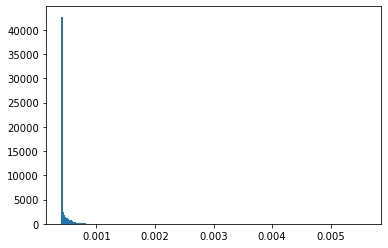

In [292]:
iLev = 10
WP2_reshape = np.squeeze(WP2_timeMean[iLev,:,:]).reshape((len(lat)*len(lon), 1))

plt.hist(WP2_reshape,bins=np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
plt.show()

In [293]:
# fig, axs = plt.subplots(2,2, figsize=(18, 12), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .3,wspace = 0.2)
# axs = axs.ravel()

# for iLev in range(4):
#     # Reshape data into 1D array
#     WP2_reshape = np.squeeze(WP2_timeMean[iLev+1,:,:]).reshape((len(lat)*len(lon), 1))
    
#     # Plot histogram
#     axs[iLev].hist(WP2_reshape,np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
#     axs[iLev].grid()
#     #axs[iLev].set_ylim([0,1200])
#     axs[iLev].set_title('Vertical Velocity Variance (WP2_CLUBB Time Mean): iLev = '+str(iLev+1), fontsize=14)
#     axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))  #Use scientific notation on x-axis
#     axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
#     axs[iLev].tick_params(labelsize=12)


### Maps

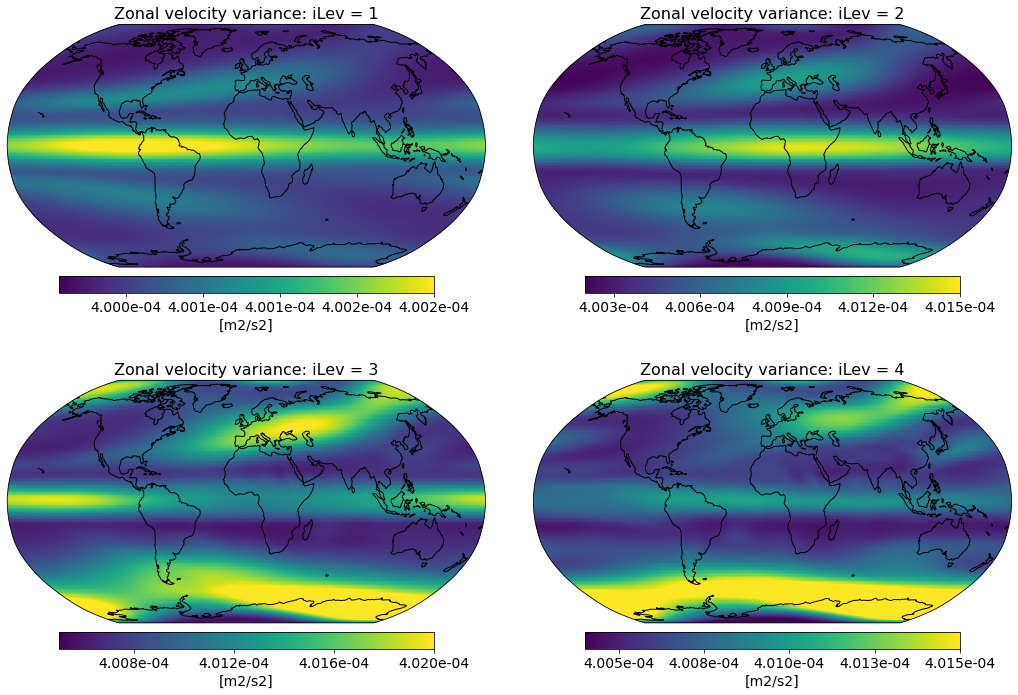

In [257]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set contour ranges to vary by level
cMin = [ 4.00005e-4, 4.002e-4, 4.0050e-4, 4.004e-4 ]
cMax = [ 4.002e-4, 4.015e-4, 4.0200e-4, 4.015e-4 ]

for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    UP2_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_timeMean[iLev+1,:,:]), dataDF.lon)
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,UP2_cyclic,
                                        vmin=cMin[iLev],
                                        vmax=cMax[iLev],
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Zonal velocity variance: iLev = '+str(iLev+1), fontsize=16)


## Testing section

Read in 1951-59 data to see if I can get all this code set up. <br>

In [122]:
# Read in CLUBB data and surface pressure values 
fileName = dataDir+nameStart+decadeList[0]+nameEnd
dataDF   = xr.open_dataset(fileName,decode_times=True) 
dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

PSfile = dataDir+nameStart+decadeList[0]+'_PS.nc'
presDF = xr.open_dataset(PSfile,decode_times=True)
presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


<ipython-input-122-44017d059483>:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-122-44017d059483>:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


In [131]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(dataDF['time'].values) 
dates.month


Int64Index([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
            ...
             4,  5,  6,  7,  8,  9, 10, 11, 12,  1],
           dtype='int64', length=108)

What does the dataframe containing CLUBB winds information look like?

In [21]:
dataDF

<xarray.Dataset>
Dimensions:    (ilev: 33, lat: 192, lon: 288, nbnd: 2, time: 108)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * ilev       (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time       (time) float64 31.0 59.0 90.0 ... 3.224e+03 3.254e+03 3.285e+03
Dimensions without coordinates: nbnd
Data variables:
    P0         float64 1e+05
    hyai       (ilev) float64 0.002255 0.005032 0.01016 ... 0.003979 0.0 0.0
    hybi       (ilev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.9389 0.9636 0.9851 1.0
    time_bnds  (time, nbnd) float64 0.0 31.0 31.0 ... 3.254e+03 3.285e+03
    PS         (time, lat, lon) float32 ...
    UP2_CLUBB  (time, ilev, lat, lon) float32 ...
    VP2_CLUBB  (time, ilev, lat, lon) float32 ...
    WP2_CLUBB  (time, ilev, lat, lon) float32 ...
    WP3_CLUBB  (time, ilev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e20.FHIST.f09_f09.cesm2_1.001
    logname:           hannay
    host:              cheyenne5
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.001.cam.i.1950-01...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    history:           Fri Aug  7 13:56:59 2020: ncrcat -v UP2_CLUBB,VP2_CLUB...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

In [22]:
np.shape(dataDF.UP2_CLUBB)

(108, 33, 192, 288)

In [43]:
np.shape(presDF.PS)

(108, 192, 288)

**Maybe interpolate?** <br>
In my previous research, I mostly wanted data on a constant pressure level, but that was also typically for pressure levels higher in the atmosphere, not near the surface. I'm going to give interpolation a shot here using NCL's vinth2p function, but most likely we'll want to keep the sigma coordinates near the surface. (Right?)

In [48]:
p0   = 1000.
pnew = [1000,975,950,925,900,850,800,750,700,600,500]

hyai = dataDF.hyai.values
hybi = dataDF.hybi.values

PS  = presDF.PS
UP2 = dataDF.UP2_CLUBB


Some context: The final argument provided to vinth2p indicates whether or not to extrapolate when the pressure level requested is outside the range of PS. For a lot of regions on the globe, that could certainly cause issue for the lower levels. So let's just take a quick look at PS average in a given month.

Text(0.5, 1.0, 'Sfc Pressure (iTime=1)')

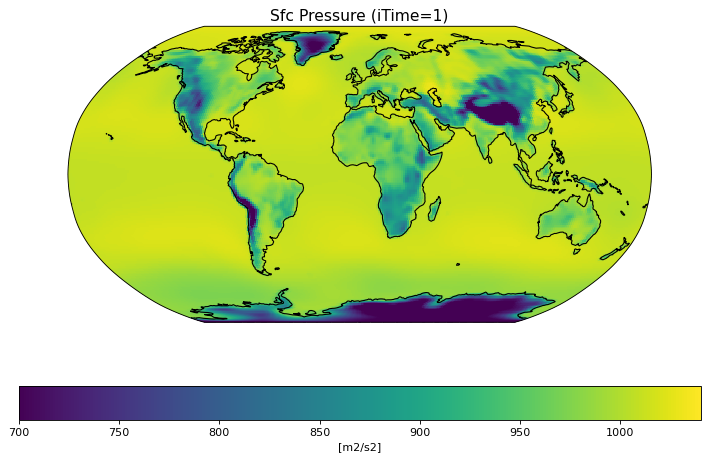

In [46]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
PS_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(PS[1,:,:]), dataDF.lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,dataDF.lat,PS_cyclic/100.0,vmin=700,vmax=1040,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[m2/s2]',orientation='horizontal')
ax.set_title('Sfc Pressure (iTime=1)', fontsize=14)



<br> Now do the actual interpolation <br>

In [49]:
# Interpolate to constant pressure levels 
UP2_new = Ngl.vinth2p(UP2,hyai,hybi,pnew,PS,1,p0,1,False)


In [51]:
# Check that arrays have expected size with new levels
print('Shape of not-interpolated data:', np.shape(UP2))
print('Shape of interpolated data:', np.shape(UP2_new))


Shape of not-interpolated data: (108, 33, 192, 288)
Shape of interpolated data: (108, 11, 192, 288)


In [52]:
# Average over time 
UP2_avg    = np.nanmean(UP2,0)
UP2new_avg = np.nanmean(UP2_new,0)


### Take a look at some summary statistics

In [58]:
len(dataDF.lat)

192

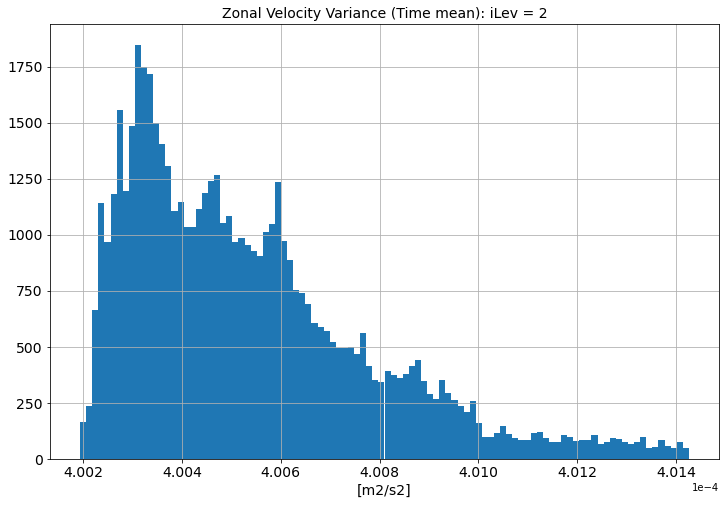

In [84]:
# --- For old data --- # 

# Specify level 
iLev = 2
UP2_reshape = np.squeeze(UP2_avg[iLev,:,:]).reshape((len(dataDF.lat)*len(dataDF.lon), 1))

# Plot histogram at various levels 
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

n, bins, patches = ax1.hist(UP2_reshape, 100)
ax1.grid()
ax1.set_title('Zonal Velocity Variance (Time mean): iLev = '+str(iLev), fontsize=14)
ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
ax1.set_xlabel('[m2/s2]',fontsize=14)
ax1.tick_params(labelsize=14)
plt.show()


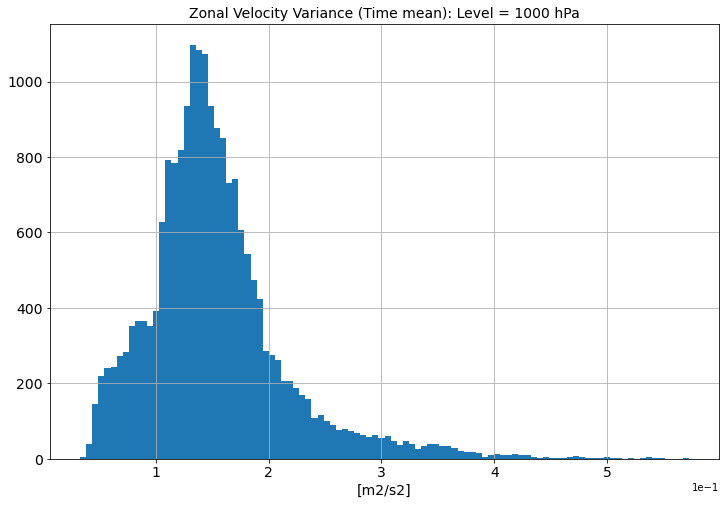

In [83]:
# --- For new data --- # 

# Specify level 
iLev = 0
UP2new_reshape = np.squeeze(UP2new_avg[iLev,:,:]).reshape((len(dataDF.lat)*len(dataDF.lon), 1))
# When data can't be extrapolated, seems like the fill value is 1e30. Set to NaN instead 
UP2new_reshape[UP2new_reshape==1e30] = np.nan 

# Plot histogram at various levels 
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

n, bins, patches = ax1.hist(UP2new_reshape, 100)
ax1.grid()
ax1.set_title('Zonal Velocity Variance (Time mean): Level = '+str(pnew[iLev])+' hPa', fontsize=14)
ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
ax1.set_xlabel('[m2/s2]',fontsize=14)
ax1.tick_params(labelsize=14)
plt.show()



Even if I mask out some of the crazy high values from vinth2p, we're still getting much bigger values of UP2_CLUBB after running the extrapolation. It feels like that would be a sign that this isn't working quite right. But, I do think it's better to stick with the sigma level anyway for right now, so I'm going to put a pin in the interpolation here.

### Try plotting

Text(0.5, 1.0, 'Zonal velocity variance (2nd lowest level; time mean, 1951-59)')

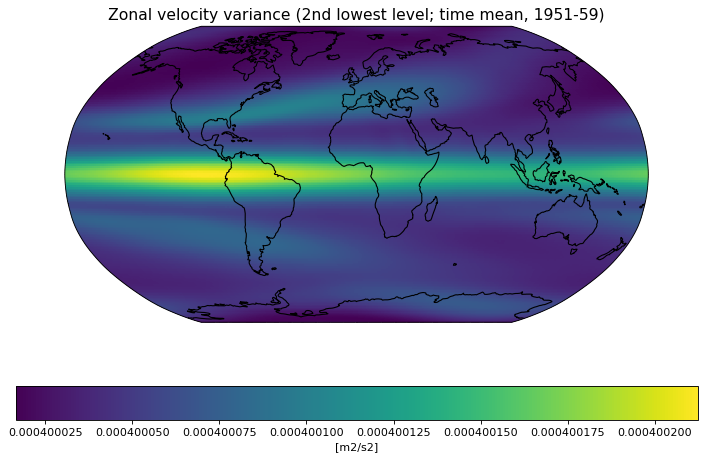

In [29]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
UP2avg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_avg[1,:,:]), dataDF.lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,dataDF.lat,UP2avg_cyclic,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[m2/s2]',orientation='horizontal')
ax.set_title('Zonal velocity variance (2nd lowest level; time mean, 1951-59)', fontsize=14)


Text(0.5, 1.0, 'Zonal velocity variance (800 mb; time mean, 1951-59)')

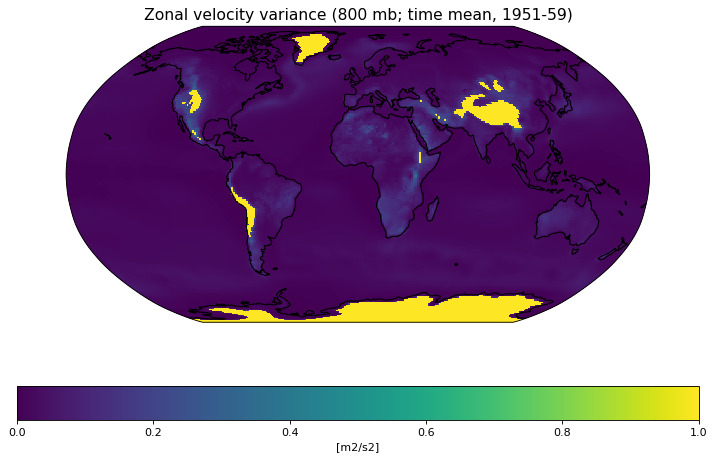

In [37]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
UP2avg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2new_avg[6,:,:]), dataDF.lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,dataDF.lat,UP2avg_cyclic,vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[m2/s2]',orientation='horizontal')
ax.set_title('Zonal velocity variance (800 mb; time mean, 1951-59)', fontsize=14)

